In [1]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Prepare Dataset
# load data

# relative path to npz files
path = 'Measurements/manual single top deformed at 20Hz'
file_name = 'output_batch_%d.npz'

def load_file(path, batch_id):
    """
    Loads in the memory a specific batch located in the given path.

    Returns a numpy NpzFile object with the image frames np array named
    as "frames" and the force measurements named as "frames".
    """
    combined_path = os.path.join(path,file_name %i)
    data = np.load(combined_path)
    return data

In [3]:
# Get dataset statistics for normalization
file_size = 1000 # one file contains 1000 samples
files_num = 2 # how many files to load
batch_size = 100 # should be something that leaves zero reminder when it divides the file_size
data_frames = []
data_forces = []
for i in range(files_num):
    data = load_file(path, i)
    data_frames.append(data['frames'])
    data_forces.append(data['forces'])
combined_frames = np.concatenate(data_frames, axis=0)
combined_forces = np.concatenate(data_forces, axis=0)
features_train = combined_frames
targets_train = combined_forces[:,2]
frames_mean = np.mean(features_train)
frames_std = np.std(features_train)
forces_z_mean = np.mean(targets_train)
forces_z_std = np.std(targets_train)
print(frames_mean)
print(frames_std)
print(forces_z_mean)
print(forces_z_std)

175.93011425797326
83.80256105196054
-0.986235911609605
1.4660020523737218


In [4]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_channels, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 9, kernel_size = 5, stride = 1, padding = 2)
        self.pool = nn.MaxPool2d(kernel_size = 4, stride = 4)
        self.conv2 = nn.Conv2d(9, 18, kernel_size = 5, stride = 1, padding = 2)
        
        # RNN
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(18 * 16 * 30, hidden_dim, layer_dim, batch_first=True, dropout = 0.2, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool(nn.ELU()(self.conv1(x)))
        x = self.pool(nn.ELU()(self.conv2(x)))
        
        # Reshape for RNN
        # x = torch.reshape(x, (100, 10, 18 * 16 * 30))
        x = torch.reshape(x, (10, 10, 18 * 16 * 30))  # Reshape to (batch_size, seq_len, input_size)
        #print("Size of x:", x.size())  # Print size of x
        
        # RNN
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        #print("Size of h0:", h0.size())  # Print size of h0 - Debugging - Obsolete
        out, hn = self.rnn(x, h0)
        
        # Output layer
        out = self.fc(out) 
        # out = torch.reshape(out, (1000, 1))
        out = torch.reshape(out, (100, 1)) # go back to compare to labels
        return out

In [5]:
# Create RNN
input_channels = 3  # RGB channels
hidden_dim = 200  # hidden layer dimension
layer_dim = 2     # number of hidden layers
output_dim = 1   # output dimension

model = RNNModel(input_channels, hidden_dim, layer_dim, output_dim)

# Define your loss function
error = nn.MSELoss()

# Define your optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Training

file_size = 1000 # one file contains 1000 samples
num_epochs = 20
files_num = 2 # how many files to load
seq_dim = 10
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
batch_size = 100 # should be something that leaves zero reminder when it divides the file_size
last_iter = -files_num * file_size/batch_size
for epoch in range(num_epochs):
    for i in range(files_num):
        data = load_file(path, i)
        
        for i in range(int(file_size/batch_size)):
            # Normalize
            normalized_frames = (data['frames'][i*batch_size:(i+1)*batch_size,:,:,:]-frames_mean)/frames_std
            normalized_forces = (data['forces'][i*batch_size:(i+1)*batch_size,2]-forces_z_mean)/forces_z_std

            # Create tensors
            images = torch.from_numpy(normalized_frames).float()
            labels = torch.from_numpy(normalized_forces).float()
                    
            # print(images.shape)  # Add this line to check the shape of images - Debugging purposes
            images = images.permute(0, 3, 1, 2)
                
            # Clear gradients
            optimizer.zero_grad()
            
            # Forward propagation
            outputs = model(images)
            outputs = torch.squeeze(outputs)
            
            # Calculate loss
            loss = error(outputs, labels)
            
            # Backpropagation
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            count += 1
                
            # Store loss and iteration
            loss_rescaled = loss.data.item() * pow(forces_z_std, 2)
            loss_list.append(loss_rescaled)
    # Print Loss
    print('Epoch: {}, MSE Loss: {}'.format((epoch+1), np.mean(loss_list[int(last_iter):])))

Epoch: 1, MSE Loss: 2.0346203176100888
Epoch: 2, MSE Loss: 1.4024891914525202
Epoch: 3, MSE Loss: 0.7079313088572781
Epoch: 4, MSE Loss: 0.4974318915506498
Epoch: 5, MSE Loss: 0.4061808170100568
Epoch: 6, MSE Loss: 0.3357644195310377
Epoch: 7, MSE Loss: 0.27088740838805947
Epoch: 8, MSE Loss: 0.23544830252361973
Epoch: 9, MSE Loss: 0.21692196734175195
Epoch: 10, MSE Loss: 0.18777411577816344
Epoch: 11, MSE Loss: 0.1727180851007039
Epoch: 12, MSE Loss: 0.164239338896895
Epoch: 13, MSE Loss: 0.16091937940312767
Epoch: 14, MSE Loss: 0.14132544568938304
Epoch: 15, MSE Loss: 0.1329812489608278
Epoch: 16, MSE Loss: 0.12508277351446823
Epoch: 17, MSE Loss: 0.1230070240758254
Epoch: 18, MSE Loss: 0.11751110808757817
Epoch: 19, MSE Loss: 0.1265378398359776
Epoch: 20, MSE Loss: 0.1182112026203727


[3.8459794845478115, 1.7106483000537893, 2.1336320655817445, 2.14791983148945, 1.6150951506448876, 1.3677554968729468, 1.2218645405873925, 2.2898360997766516, 2.1092183759211123, 2.084485845264351, 1.8292021956973263, 2.2434105961795434, 1.924655811376219, 1.9114497221946347, 1.8054192706268672, 2.290915470702078, 1.811901260681162, 1.5062443205267868, 2.337932540277541, 2.5048399731994806, 2.908068150771203, 1.4993284556416806, 1.656928267857409, 1.7623510128419555, 1.1609568152239509, 0.8960865430665972, 0.7007077877106646, 1.7602290357021877, 1.5337185763101677, 1.386472449716035, 1.2938763615986757, 1.4278624688949644, 1.2277349810573075, 1.2350330964576608, 1.098828936992638, 1.4412057532179126, 1.0426563655068268, 0.7187560583521477, 1.6940811220588499, 1.6049015900715689, 1.733107823625248, 0.8288345351903791, 0.7484941620680701, 0.6639471117774641, 0.5856854820318881, 0.4572103664971419, 0.3070073707615247, 0.7071596742558832, 0.7216354910202855, 0.6456197111518244, 0.483055317

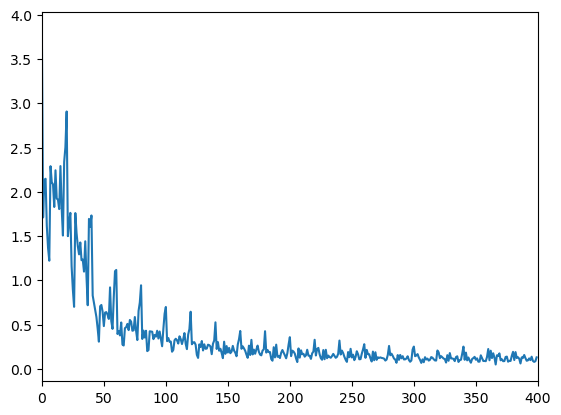

In [7]:
print(loss_list)
print(np.sqrt(np.mean(loss_list[-20:])))
plt.plot(range(len(loss_list)), loss_list)
plt.xlim((0,400))
plt.show()

In [12]:
print(outputs * forces_z_std + forces_z_mean) # Small sanity check

tensor([-2.5213, -0.9030, -0.4364, -0.4514, -0.3003, -0.0480, -0.1677, -0.2873,
        -0.0945, -0.1872, -0.1810, -0.1620, -0.1700, -0.2049, -0.0483, -0.0389,
        -0.1486, -0.0696, -0.2022,  0.0313, -0.0783, -0.0442, -0.0848, -0.1598,
        -0.0950, -0.0282, -0.0570,  0.0240, -0.0866,  0.0215, -0.1561, -0.6870,
        -2.0573, -2.6405, -3.2821, -3.5096, -3.5445, -4.3443, -4.4061, -4.2597,
        -4.6489, -4.0706, -4.8691, -4.9482, -3.8679, -2.2949, -0.1590, -0.1315,
        -0.1995, -0.2663, -0.5487, -0.5789, -0.3027, -0.2801, -0.2730, -0.0591,
        -0.1873, -0.2447, -0.2966, -0.2245, -0.1729, -0.1715, -0.3227, -0.0711,
         0.0311, -0.0103, -0.1656,  0.0213,  0.0681,  0.0877, -0.1775, -0.2209,
        -0.4103, -0.7196, -1.9569, -2.6826, -3.1260, -3.8518, -3.8795, -3.9968,
        -3.8921, -4.2008, -4.5738, -4.3753, -4.5541, -3.3270, -2.5905, -0.1245,
        -0.0222, -0.1378, -0.6039, -0.6208, -0.4742, -0.3454, -0.3041, -0.1308,
        -0.0975, -0.3998, -0.2225, -0.27

In [13]:
print(labels.float() * forces_z_std + forces_z_mean)

tensor([-0.9837, -0.1637, -0.1279, -0.1309, -0.1346, -0.1297, -0.1344, -0.1294,
        -0.1343, -0.1282, -0.1322, -0.1240, -0.1298, -0.1313, -0.1317, -0.1270,
        -0.1292, -0.1361, -0.1341, -0.1336, -0.1390, -0.1233, -0.1278, -0.1282,
        -0.1346, -0.1320, -0.1334, -0.1283, -0.1324, -0.3513, -1.0552, -1.5855,
        -2.5075, -2.8629, -3.2809, -3.5987, -4.0110, -4.4015, -4.5454, -4.9288,
        -5.1063, -5.1722, -4.9448, -4.5689, -3.3009, -1.5864, -0.2401, -0.1187,
        -0.1239, -0.1288, -0.1313, -0.1257, -0.1342, -0.1297, -0.1307, -0.1230,
        -0.1293, -0.1233, -0.1307, -0.1248, -0.1389, -0.1326, -0.1363, -0.1292,
        -0.1340, -0.1309, -0.1326, -0.1288, -0.1315, -0.1237, -0.1371, -0.3839,
        -0.8983, -1.3171, -2.2785, -2.7973, -3.4132, -3.8083, -4.2586, -4.6140,
        -4.6368, -4.7420, -4.7785, -4.7576, -4.3578, -3.5074, -1.8832, -0.4341,
        -0.1187, -0.1313, -0.1282, -0.1306, -0.1325, -0.1369, -0.1345, -0.1265,
        -0.1310, -0.1315, -0.1313, -0.12

Notes: Batch size of 100, sequence length of 10, dropout of 20%, normalization implemented.